In [8]:
import numpy as np
import torch
import meshplot as mp # useful for visualizing
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import primitive
import trimesh

In [9]:
# Loading a mesh and do uniformly samplings on the surface
mesh = trimesh.load_mesh('clip/clip_0_gap.obj')  # ground truth: [width, height, thickness, dist, open_gap] = [20, 15, 1, 15, 10]

# Sample points uniformly from the surface of the mesh
points, _ = trimesh.sample.sample_surface_even(mesh, 1000)
points_numpy = np.array(points)
points_tensor = torch.tensor(points_numpy, dtype=torch.float32)

  0%|          | 0/2000 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

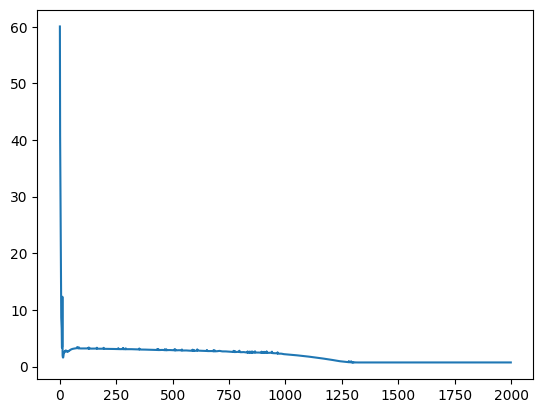

In [10]:
# diff. learning on a certain mesh input
import pytorch3d 
from pytorch3d.loss import chamfer_distance

# opt_params = torch.randn(11)
# opt_params[-5:] = torch.abs(opt_params[-5:])
# opt_params[:3] = torch.tensor([0,0,0.])
# opt_params[3:6] = torch.tensor([0.,0,1])
# torch.tensor([20., 20,  1,  3,  0])
opt_params = torch.randn(5)
opt_params[-1] = 0.0
opt_params[2] = (opt_params[3]) / 2 - 0.01
# opt_params = torch.tensor([1.,1,1,1,1])
opt_params.requires_grad = True

optimizer = torch.optim.Adam([opt_params], 2.5) # 0.1 is a good lr, 1 is not good

uv_coordinates = torch.rand((1000,2))
losses = []

points_tensor = points_tensor.view(1, -1, 3)


for _ in tqdm(range(2000)):
    optimizer.zero_grad()
    opt_points = primitive.clip(opt_params, uv_coordinates)
    opt_points = opt_points.view(1, -1, 3)
    
    loss = chamfer_distance(x = points_tensor, y = opt_points)
    loss = loss[0]
    
    loss.backward()
    optimizer.step()

    with torch.no_grad(): 
        opt_params[:5] = torch.abs(opt_params[:5])
        if opt_params[2] >= (opt_params[3]) / 2:
            opt_params[2] = (opt_params[3]) / 2 - 0.1
        # opt_params[4] =opt_params[3] - 0.1

    losses.append(loss.detach().item())
plt.plot(losses)
plt.show 


In [11]:
print(losses[-1])

0.718080997467041


In [12]:
# compare the original mesh with the optimized mesh

# probably the original mesh have the top, bottom, front and back faces, need to remove them and run learning again.

points_tensor = points_tensor.reshape(-1, 1, 3)
plot = mp.plot(points_tensor.detach().numpy(), return_plot=True, shading={'point_size':2})

opt_points = opt_points.reshape(-1, 1, 3)
plot.add_points(opt_points.detach().numpy(), shading={'point_size':2, 'point_color':'green'})
print(opt_params)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0009764…

tensor([20.1403, 19.9157,  1.0528,  2.9430,  0.0000], requires_grad=True)


In [13]:
# check opt_params by plotting original mesh with the points cloud got by opt_params
plot = mp.plot(points_tensor.detach().numpy(), return_plot=True, shading={'point_size':2})

# opt_params is just the final parameters, so we have center, position, radius stored in opt_params
coordinates = torch.rand((1000, 2))
points = primitive.clip(opt_params, coordinates).detach().numpy()
plot.add_points(points, shading={'point_size':2, 'point_color':'green'})
print(opt_params)  ## ground truth: [width, height, thickness, dist, open_gap] = [20, 15, 1, 15, 10]  , center = [0 0 0], orientation = [0 0 1] (z-axis)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0009764…

tensor([20.1403, 19.9157,  1.0528,  2.9430,  0.0000], requires_grad=True)


In [16]:
import numpy as np
import torch
import meshplot as mp # useful for visualizing
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import primitive
import trimesh

mesh = trimesh.load_mesh('clip/clip_0_gap.obj')  # ground truth: [width, height, thickness, dist, open_gap] = [20, 15, 1, 15, 10]
points, _ = trimesh.sample.sample_surface_even(mesh, 1000)
points_numpy = np.array(points)
points_tensor = torch.tensor(points_numpy, dtype=torch.float32)
points_tensor = points_tensor.reshape(-1, 1, 3)
plot = mp.plot(points_tensor.detach().numpy(), return_plot=True, shading={'point_size':2})

coordinates = torch.rand((1000, 2))
check = primitive.clip(torch.tensor([20, 20, 1,  3,  0], dtype=torch.float32), coordinates).detach().numpy()
plot.add_points(check, shading={'point_size':2, 'point_color':'black'}) 

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0026352…

1